# Step 1: GPT-2 인스트럭션 튜닝(SFT)

__SAWYER 파인튜닝 절차__

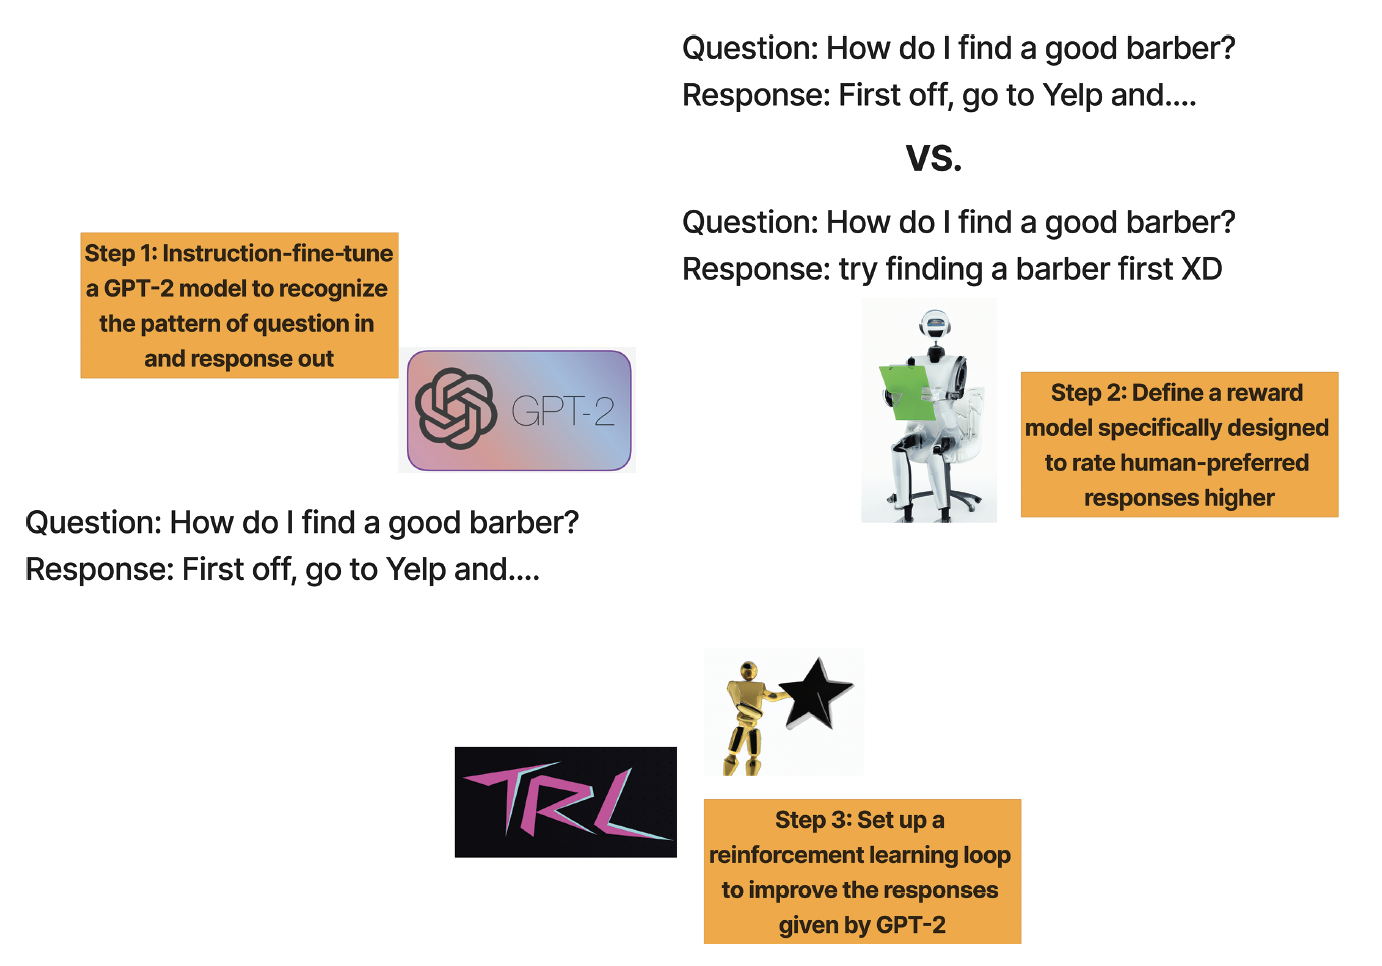

# 1. 데이터 로딩

In [1]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, pipeline, \
                         AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from datasets import Dataset, load_dataset
import torch
import json

In [2]:
seed=42

In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda")

device

device(type='cuda')

In [4]:
training_df = pd.read_csv('../data/chip2.csv')

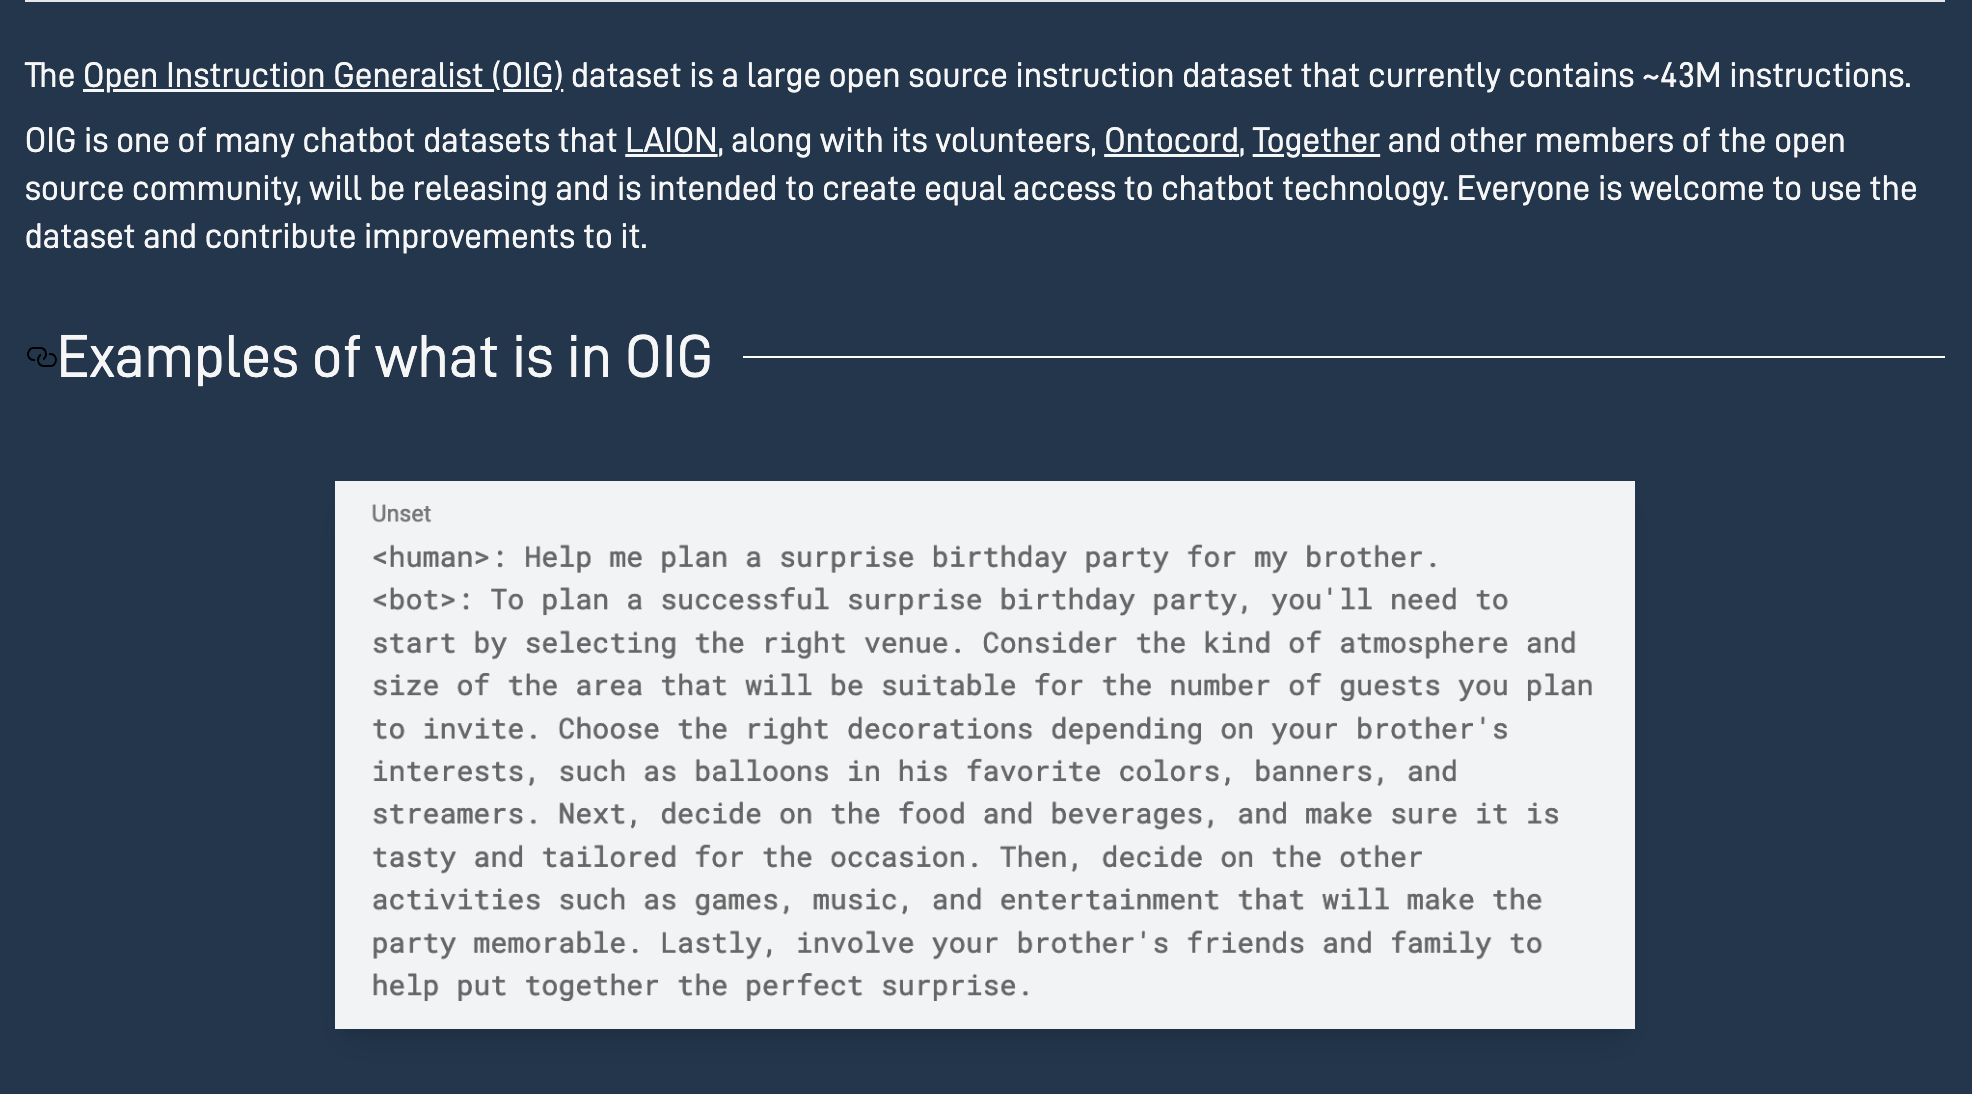

Find it [here](https://laion.ai/blog/oig-dataset/)

In [5]:
training_df.head()

prompt  \
0  What is the name of the architect of the DeGol...   
1                        Why did the US invade Iraq?   
2                      Can I make a typhoid vaccine?   
3  What's the best way to deal with an annoying c...   
4  Is it safe to drink alcohol if I have a histor...   

                                            response         source  
0  The architect of the DeGolyer House is Richard...  unified_chip2  
1  The US invaded Iraq in 2003 based on the belie...  unified_chip2  
2  Yes, typhoid vaccines are available and can be...  unified_chip2  
3  It's always best to approach the situation cal...  unified_chip2  
4  No, it is not safe to drink alcohol if you hav...  unified_chip2

In [6]:
print(training_df.iloc[798]['prompt'])
print(training_df.iloc[798]['response'])

Is there a list of all the U.S. presidents and when they served?
Yes, here is a list of all the U.S. presidents in chronological order and the dates they served:

George Washington (1789-1797)
John Adams (1797-1801)
Thomas Jefferson (1801-1809)
James Madison (1809-1817)
James Monroe (1817-1825)
John Quincy Adams (1825-1829)
Andrew Jackson (1829-1837)
Martin Van Buren (1837-1841)
William Henry Harrison (1841)
John Tyler (1841-1845)
James K. Polk (1845-1849)
Zachary Taylor (1849-1850)
Millard Fillmore (1850-1853)
Franklin Pierce (1853-1857)
James Buchanan (1857-1861)
Abraham Lincoln (1861-1865)
Andrew Johnson (1865-1869)
Ulysses S. Grant (1869-1877)
Rutherford B. Hayes (1877-1881)
James A. Garfield (1881)
Chester A. Arthur (1881-1885)
Grover Cleveland (1885-1889)
Benjamin Harrison (1889-1893)
Grover Cleveland (1893-1897)
William McKinley (1897-1901)
Theodore Roosevelt (1901-1909)
William Howard Taft (1909-1913)
Woodrow Wilson (1913-1921)
Warren G. Harding (1921-1923)
Calvin Coolidge (192

In [7]:
training_df.shape

(173734, 3)

In [8]:
training_df['response'] = training_df['response'].map(lambda x: x.strip())
training_df['prompt'] = training_df['prompt'].map(lambda x: x.strip())

In [9]:
training_df = training_df.drop_duplicates(subset=['prompt'])  # drop duplicate prompts, just in case

In [10]:
training_df.shape

(112097, 3)

In [11]:
training_df.head(2)

prompt  \
0  What is the name of the architect of the DeGol...   
1                        Why did the US invade Iraq?   

                                            response         source  
0  The architect of the DeGolyer House is Richard...  unified_chip2  
1  The US invaded Iraq in 2003 based on the belie...  unified_chip2

<Axes: xlabel='source'>

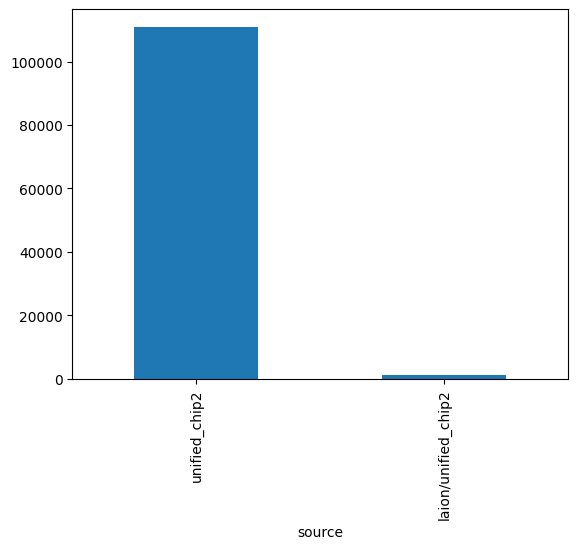

In [12]:
training_df['source'].value_counts().plot(kind='bar')

In [13]:
training_df.shape

(112097, 3)

<Axes: title={'center': 'Histogram of prompt Length'}, ylabel='Frequency'>

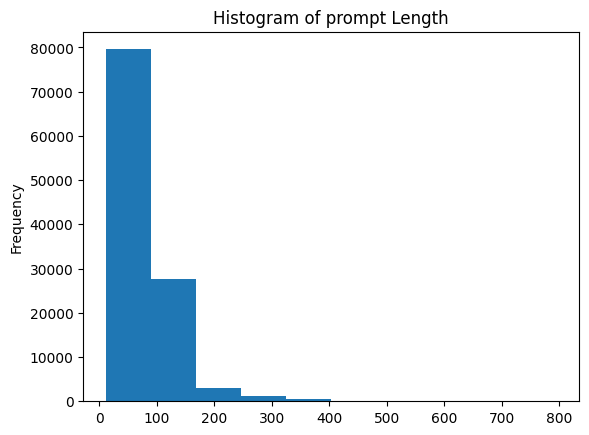

In [14]:
training_df['prompt'].str.len().plot(kind='hist', title='Histogram of prompt Length')

<Axes: title={'center': 'Histogram of response Length'}, ylabel='Frequency'>

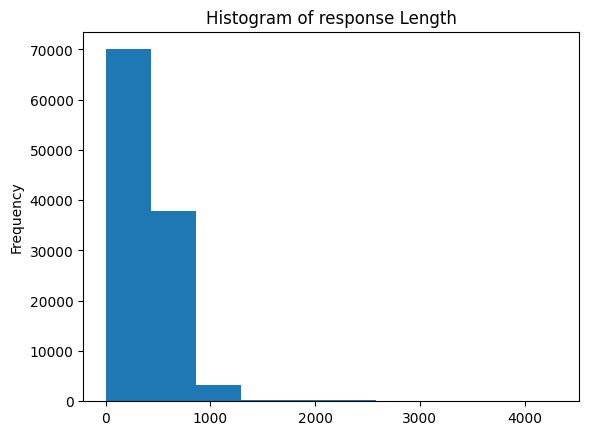

In [15]:
training_df['response'].str.len().plot(kind='hist', title='Histogram of response Length')

In [16]:
QUERY_KEY = "Question:"
RESPONSE_KEY = "Response:"
PAD_KEY = "<PAD>"

# 2. 모델 로딩

이 코드는 Hugging Face의 `transformers` 라이브러리를 사용하여 GPT-2 모델과 토크나이저를 불러오고, 새로운 특수 토큰을 추가하며, 모델의 토큰 임베딩을 조정하는 과정을 보여줍니다.

코드를 단계별로 설명하겠습니다:

1. `MODEL = 'gpt2'`: 사용할 모델의 이름을 지정합니다. 여기서는 'gpt2'를 사용하여 GPT-2 모델을 불러옵니다.

2. `tokenizer = AutoTokenizer.from_pretrained(MODEL)`: `AutoTokenizer`를 사용하여 지정된 모델에 해당하는 토크나이저를 불러옵니다. 이 경우 GPT-2 모델의 토크나이저가 로드됩니다.

3. `print(len(tokenizer))`: 토크나이저의 초기 토큰 개수를 출력합니다.

4. `tokenizer.add_special_tokens({"additional_special_tokens": [QUERY_KEY, RESPONSE_KEY, PAD_KEY]})`: 토크나이저에 새로운 특수 토큰을 추가합니다. `QUERY_KEY`, `RESPONSE_KEY`, `PAD_KEY`는 사용자 정의 토큰으로, 각각 쿼리, 응답, 패딩을 나타내는 데 사용됩니다. 많은 대규모 언어 모델(LLMs)에서는 이러한 예약된 토큰을 사용합니다.

5. `tokenizer.pad_token = PAD_KEY`: 토크나이저의 패딩 토큰을 `PAD_KEY`로 설정합니다. 이는 시퀀스의 길이를 맞추기 위해 사용되는 특수 토큰입니다.

6. `print(len(tokenizer))`: 새로운 특수 토큰이 추가된 후의 토크나이저의 토큰 개수를 출력합니다.

7. `model = AutoModelForCausalLM.from_pretrained(MODEL)`: `AutoModelForCausalLM`을 사용하여 지정된 모델에 해당하는 인과 언어 모델(Causal Language Model)을 불러옵니다. 이 경우 GPT-2 모델이 로드됩니다.

8. `model.config.pad_token = PAD_KEY`: 모델의 설정(configuration)에서 패딩 토큰을 `PAD_KEY`로 설정합니다. 이는 모델이 패딩 토큰을 인식할 수 있도록 합니다.

9. `model.resize_token_embeddings(len(tokenizer))`: 모델의 토큰 임베딩 크기를 조정합니다. 새로운 특수 토큰이 추가되었으므로, 모델의 임베딩 크기를 토크나이저의 토큰 개수에 맞게 조정해야 합니다. 이렇게 하면 모델이 새로운 토큰을 인식할 수 있습니다.

위의 코드를 통해 GPT-2 모델과 토크나이저를 불러오고, 사용자 정의 특수 토큰을 추가하며, 모델의 토큰 임베딩 크기를 조정하는 과정을 수행합니다. 이는 대규모 언어 모델을 fine-tuning하거나 특정 태스크에 맞게 조정할 때 일반적으로 수행되는 단계입니다.

In [17]:
MODEL = 'gpt2'

tokenizer = AutoTokenizer.from_pretrained(MODEL)

print(len(tokenizer))

# Adding new tokens to represent query, pad, and response. Many LLMs use reserved tokens.
tokenizer.add_special_tokens({"additional_special_tokens": [QUERY_KEY, RESPONSE_KEY, PAD_KEY]})
tokenizer.pad_token = PAD_KEY

print(len(tokenizer))

model = AutoModelForCausalLM.from_pretrained(MODEL)
model.config.pad_token = PAD_KEY
model.resize_token_embeddings(len(tokenizer))

50257
50260


Embedding(50260, 768)

이 코드는 데이터셋을 전처리하고 토크나이즈하는 과정을 보여줍니다. 데이터셋은 Pandas DataFrame인 `training_df`에서 로드되며, Hugging Face의 `Dataset` 클래스를 사용하여 `chip2_dataset`으로 변환됩니다.

코드를 단계별로 설명하겠습니다:

1. `chip2_dataset = Dataset.from_pandas(training_df)`: Pandas DataFrame인 `training_df`에서 `Dataset` 객체를 생성합니다. 이렇게 하면 Hugging Face의 `Dataset` 클래스를 사용하여 데이터셋을 다룰 수 있습니다.

2. `preprocess` 함수 정의:
   - `preprocess` 함수는 데이터셋의 각 예제(example)에 대해 호출되는 전처리 함수입니다.
   - 이 함수는 `example` 매개변수를 받아, 프롬프트(prompt)와 응답(response)을 결합하여 토크나이저에 전달합니다.
   - `QUERY_KEY`와 `RESPONSE_KEY`는 프롬프트와 응답을 구분하는 특수 토큰입니다.
   - 프롬프트와 응답 사이에는 개행 문자(`\n`)가 삽입되고, 응답 뒤에는 `tokenizer.eos_token`이 추가됩니다.
   - 토크나이저는 입력 텍스트를 토큰화하고 인코딩합니다.

3. `chip2_dataset = chip2_dataset.map(...)`: `map` 함수를 사용하여 데이터셋의 각 예제에 `preprocess` 함수를 적용합니다.
   - `batched=False`는 예제를 배치 단위로 처리하지 않고 개별적으로 처리함을 의미합니다.
   - `batch_size=1024`는 한 번에 처리할 예제의 수를 지정합니다.
   - `remove_columns=chip2_dataset.features.keys()`는 원본 데이터셋의 열(column)을 제거하고 전처리된 데이터만 남기도록 합니다.

4. `filter_function` 함수 정의:
   - `filter_function`은 데이터셋의 각 예제에 대해 호출되는 필터링 함수입니다.
   - 이 함수는 `example` 매개변수를 받아, 입력 ID의 길이가 1024 이하인 예제만 필터링합니다.

5. `chip2_dataset = chip2_dataset.filter(filter_function)`: `filter` 함수를 사용하여 `filter_function`의 조건에 맞는 예제만 선택합니다. 즉, 입력 ID의 길이가 1024 이하인 예제만 남게 됩니다.

6. `chip2_dataset = chip2_dataset.train_test_split(test_size=0.2, seed=seed)`: 데이터셋을 훈련 세트와 테스트 세트로 분할합니다.
   - `test_size=0.2`는 테스트 세트의 비율을 20%로 설정합니다.
   - `seed=seed`는 분할 시 사용할 랜덤 시드를 지정합니다.

위의 코드를 통해 데이터셋을 전처리하고 토크나이즈하며, 입력 시퀀스의 길이에 따라 필터링하고, 훈련 세트와 테스트 세트로 분할하는 과정을 수행합니다. 이렇게 전처리된 데이터셋은 모델 학습 및 평가에 사용될 수 있습니다.

In [26]:
chip2_dataset = Dataset.from_pandas(training_df)

In [27]:
chip2_dataset

Dataset({
    features: ['prompt', 'response', 'source', '__index_level_0__'],
    num_rows: 112097
})

In [28]:
len(chip2_dataset)

112097

In [29]:
def preprocess(example):
    return tokenizer(QUERY_KEY+ ' ' + example['prompt'] + '\n'+RESPONSE_KEY+' '+example['response']+tokenizer.eos_token)

chip2_dataset = chip2_dataset.map(
    preprocess, batched=False, batch_size=1024, remove_columns=chip2_dataset.features.keys()
)

def filter_function(example):
    return len(example['input_ids']) <= 512

chip2_dataset = chip2_dataset.filter(filter_function)

print(len(chip2_dataset))

chip2_dataset = chip2_dataset.train_test_split(test_size=0.2, seed=seed)

Map:   0%|          | 0/112097 [00:00<?, ? examples/s]

Filter:   0%|          | 0/112097 [00:00<?, ? examples/s]

111692


In [35]:
print(len(chip2_dataset['train']))

89353


In [34]:
print(len(chip2_dataset['test']))

22339


In [36]:
chip2_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 89353
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 22339
    })
})

In [37]:
chip2_dataset['test']['input_ids'][13]

[50257,
 7731,
 6612,
 642,
 1866,
 7074,
 1271,
 287,
 383,
 440,
 5796,
 24764,
 30,
 198,
 50258,
 3363,
 11,
 383,
 6612,
 642,
 550,
 1936,
 1866,
 981,
 383,
 440,
 5796,
 24764,
 550,
 1440,
 13,
 50256]

In [38]:
print(tokenizer.decode(chip2_dataset['test']['input_ids'][13]))
print('-----')
print(tokenizer.decode(chip2_dataset['test']['input_ids'][14]))
print('-----')
print(tokenizer.decode(chip2_dataset['test']['input_ids'][63]))

Question: Did Jackson 5 members exceed number in The Osmonds?
Response: Yes, The Jackson 5 had five members while The Osmonds had four.<|endoftext|>
-----
Question: I'm moving to a new city! What should I know before I go?
Response: Congrats on the move! Some things to consider before relocating to a new city: research the neighborhoods and their safety, cost of living, public transportation availability, job market, and local culture/attractions. It's also a good idea to connect with locals or join community groups to get a feel for the area and make new friends. Happy moving!<|endoftext|>
-----
Question: Where can I find a list of the most popular songs?
Response: There are several websites where you can find a list of the most popular songs. Some of the most popular ones include Billboard, Rolling Stone, and Spotify. You can also check out music blogs and magazines for their own lists of popular songs.<|endoftext|>


In [39]:
len(chip2_dataset['test']['input_ids'][0])

98

In [40]:
f'{model.num_parameters():,}'

'124,442,112'

# 3. 모델 학습

In [41]:
import wandb
# Set up Weights and Biases integration
wandb.init(project="sawyer")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [42]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
# print(torch.cuda.get_device_name(0))
if device.type == 'cuda':
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



이 코드는 Hugging Face의 `transformers` 라이브러리에서 제공하는 `DataCollatorForLanguageModeling` 클래스를 사용하여 언어 모델링을 위한 데이터 콜레이터(Data Collator)를 생성하는 부분입니다.

데이터 콜레이터는 데이터셋의 배치(batch)를 전처리하고 모델에 입력으로 사용할 수 있는 형태로 변환하는 역할을 합니다. `DataCollatorForLanguageModeling`은 언어 모델링 태스크에 특화된 데이터 콜레이터입니다.

코드를 자세히 살펴보겠습니다:

```python
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
    return_tensors="pt", pad_to_multiple_of=8
)
```

- `tokenizer=tokenizer`: 사용할 토크나이저를 지정합니다. 이전에 생성한 `tokenizer` 객체를 전달합니다.

- `mlm=False`: MLM(Masked Language Modeling) 태스크를 수행하지 않도록 설정합니다. MLM은 BERT와 같은 모델의 사전 학습에 사용되는 기법으로, 입력 시퀀스에서 일부 토큰을 마스킹하고 모델이 마스킹된 토큰을 예측하도록 학습합니다. 여기서는 MLM을 사용하지 않고 일반적인 언어 모델링을 수행합니다.

- `return_tensors="pt"`: 반환되는 텐서의 형태를 PyTorch 텐서로 지정합니다. "pt"는 PyTorch를 의미합니다.

- `pad_to_multiple_of=8`: 배치 내의 시퀀스를 패딩할 때, 시퀀스의 길이를 8의 배수로 맞추도록 설정합니다. 이는 일부 하드웨어 또는 모델 아키텍처에서 효율적인 연산을 위해 사용됩니다.

데이터 콜레이터는 다음과 같은 작업을 수행합니다:

1. 배치 내의 시퀀스를 토크나이저를 사용하여 토큰화합니다.
2. 시퀀스의 길이를 동일하게 맞추기 위해 패딩을 수행합니다.
3. MLM 태스크를 수행하지 않도록 설정되어 있으므로, 마스킹된 토큰은 생성되지 않습니다.
4. 패딩된 시퀀스를 PyTorch 텐서로 변환합니다.
5. 시퀀스의 길이를 8의 배수로 맞추기 위해 추가적인 패딩을 수행합니다.

생성된 `data_collator`는 `Trainer` 클래스의 `data_collator` 매개변수에 전달되어 모델 학습 과정에서 사용됩니다.

```python
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator
)
```

위의 코드와 같이 `Trainer`에 `data_collator`를 전달하면, 모델 학습 과정에서 데이터 콜레이터가 배치를 전처리하고 모델에 입력으로 사용할 수 있는 형태로 변환합니다.

In [43]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
    return_tensors="pt", pad_to_multiple_of=8
)

이 코드는 Hugging Face의 `transformers` 라이브러리에서 제공하는 `TrainingArguments` 클래스를 사용하여 모델 학습을 위한 설정을 정의하는 부분입니다.

`TrainingArguments`는 모델 학습 과정을 제어하는 다양한 하이퍼파라미터와 설정을 포함하고 있습니다. 코드에서 사용된 주요 매개변수들을 설명하겠습니다:

- `output_dir="./sawyer_supervised_instruction"`: 모델의 체크포인트, 로그 파일 등이 저장될 출력 디렉토리를 지정합니다.

- `overwrite_output_dir=True`: 출력 디렉토리가 이미 존재하는 경우 해당 디렉토리의 내용을 덮어쓰도록 설정합니다.

- `num_train_epochs=1`: 학습 에포크(epoch) 수를 지정합니다. 전체 학습 데이터셋을 1번 반복하여 학습합니다.

- `per_device_train_batch_size=2`: 학습 시 각 디바이스(GPU 또는 CPU)에서 사용할 배치 크기를 지정합니다. 여기서는 2로 설정되어 있습니다.

- `per_device_eval_batch_size=4`: 평가 시 각 디바이스에서 사용할 배치 크기를 지정합니다. 여기서는 4로 설정되어 있습니다.

- `gradient_accumulation_steps=16`: 그레이디언트 누적(gradient accumulation) 단계 수를 지정합니다. 이는 실제 배치 크기를 늘리는 효과가 있습니다. 여기서는 16으로 설정되어 있으므로, 실제 배치 크기는 `per_device_train_batch_size * gradient_accumulation_steps`가 됩니다.

- `load_best_model_at_end=True`: 학습이 끝난 후 검증 손실(validation loss)이 가장 낮은 모델을 로드하도록 설정합니다.

- `evaluation_strategy='epoch'`: 평가 전략을 설정합니다. 여기서는 'epoch'으로 설정되어 있어 매 에포크마다 평가를 수행합니다.

- `save_strategy='epoch'`: 모델 저장 전략을 설정합니다. 여기서는 'epoch'으로 설정되어 있어 매 에포크마다 모델을 저장합니다.

- `report_to="all"`: 학습 과정에서 로그와 메트릭을 보고할 대상을 지정합니다. "all"로 설정되어 있어 사용 가능한 모든 대상(예: TensorBoard, Weights & Biases 등)에 보고합니다.

- `seed=seed`: 학습에 사용되는 랜덤 시드를 지정합니다. 재현 가능한 결과를 얻기 위해 시드를 고정합니다.

- `fp16=False`: 혼합 정밀도(mixed precision) 학습을 비활성화합니다. 여기서는 False로 설정되어 있어 일반적인 단정도(single precision) 학습을 수행합니다.

위의 설정들은 `Trainer` 클래스의 `args` 매개변수에 전달되어 모델 학습 과정을 제어하는 데 사용됩니다.

```python
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator
)
```

위의 코드와 같이 `Trainer`에 `training_args`를 전달하면, 지정된 설정에 따라 모델 학습이 수행됩니다.

In [44]:
training_args = TrainingArguments(
    output_dir="./sawyer_supervised_instruction",  # The output directory
    overwrite_output_dir=True,  # overwrite the content of the output directory
    num_train_epochs=1,  # number of training epochs
    per_device_train_batch_size=2,  # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    gradient_accumulation_steps=16,  # steps for gradient accumulation
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    report_to="all",
    seed=seed,
    fp16=False,  # enable mixed precision training for my GPU
)

이 코드는 Hugging Face의 `transformers` 라이브러리에서 제공하는 `Trainer` 클래스를 사용하여 모델 학습을 위한 `Trainer` 객체를 생성하는 부분입니다.

`Trainer` 클래스는 모델 학습 과정을 관리하고 실행하는 역할을 합니다. 주요 매개변수들을 설명하겠습니다:

- `model=model`: 학습할 모델을 지정합니다. 이전에 정의한 `model` 객체를 전달합니다.

- `args=training_args`: 학습 설정을 지정합니다. 이전에 정의한 `TrainingArguments` 객체인 `training_args`를 전달합니다. 이 객체는 학습 에포크 수, 배치 크기, 출력 디렉토리 등의 설정을 포함하고 있습니다.

- `train_dataset=chip2_dataset['train']`: 학습에 사용할 훈련 데이터셋을 지정합니다. `chip2_dataset`은 이전에 전처리된 데이터셋이며, `'train'`은 훈련 데이터셋을 의미하는 키입니다.

- `eval_dataset=chip2_dataset['test']`: 평가에 사용할 검증 데이터셋을 지정합니다. `'test'`는 검증 데이터셋을 의미하는 키입니다.

- `data_collator=data_collator`: 데이터 콜레이터를 지정합니다. 이전에 정의한 `DataCollatorForLanguageModeling` 객체인 `data_collator`를 전달합니다. 데이터 콜레이터는 데이터셋의 배치를 전처리하고 모델에 입력으로 사용할 수 있는 형태로 변환하는 역할을 합니다.

위의 매개변수들을 전달하여 `Trainer` 객체를 생성하면, 모델 학습을 위한 환경이 설정됩니다. `Trainer`는 내부적으로 학습 과정을 관리하고 실행하는 다양한 메서드를 제공합니다.

`Trainer`의 주요 메서드는 다음과 같습니다:

- `train()`: 모델 학습을 시작합니다. 지정된 에포크 수만큼 학습을 반복합니다.
- `evaluate()`: 모델을 평가합니다. 검증 데이터셋을 사용하여 모델의 성능을 측정합니다.
- `save_model()`: 학습된 모델을 저장합니다.

예를 들어, 다음과 같이 `trainer.train()`을 호출하여 모델 학습을 시작할 수 있습니다:

```python
trainer.train()
```

학습이 완료되면 `trainer.evaluate()`를 호출하여 모델의 성능을 평가할 수 있습니다:

```python
eval_results = trainer.evaluate()
print(eval_results)
```

또한, `trainer.save_model()`을 사용하여 학습된 모델을 저장할 수 있습니다.

이렇게 `Trainer` 클래스를 사용하면 모델 학습 과정을 간편하게 관리하고 실행할 수 있으며, 학습된 모델을 평가하고 저장할 수 있습니다.

In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=chip2_dataset['train'],
    eval_dataset=chip2_dataset['test'],
    data_collator=data_collator
)

In [46]:
trainer.evaluate()

{'eval_loss': 82.2848129272461,
 'eval_runtime': 870.243,
 'eval_samples_per_second': 25.67,
 'eval_steps_per_second': 6.418}

이 코드는 Hugging Face의 `transformers` 라이브러리에서 제공하는 `TrainingArguments` 클래스를 사용하여 모델 학습을 위한 설정을 정의하는 부분입니다.

`TrainingArguments`는 모델 학습 과정을 제어하는 다양한 하이퍼파라미터와 설정을 포함하고 있습니다. 코드에서 사용된 주요 매개변수들을 설명하겠습니다:

- `output_dir="./sawyer"`: 모델의 체크포인트, 로그 파일 등이 저장될 출력 디렉토리를 지정합니다.

- `overwrite_output_dir=True`: 출력 디렉토리가 이미 존재하는 경우 해당 디렉토리의 내용을 덮어쓰도록 설정합니다.

- `num_train_epochs=1`: 학습 에포크(epoch) 수를 지정합니다. 전체 학습 데이터셋을 1번 반복하여 학습합니다.

- `per_device_train_batch_size=1`: 학습 시 각 디바이스(GPU 또는 CPU)에서 사용할 배치 크기를 지정합니다. 여기서는 1로 설정되어 있습니다.

- `per_device_eval_batch_size=1`: 평가 시 각 디바이스에서 사용할 배치 크기를 지정합니다. 여기서도 1로 설정되어 있습니다.

- `gradient_accumulation_steps=32`: 그레이디언트 누적(gradient accumulation) 단계 수를 지정합니다. 이는 실제 배치 크기를 늘리는 효과가 있습니다. 여기서는 32로 설정되어 있으므로, 실제 배치 크기는 `per_device_train_batch_size * gradient_accumulation_steps`가 됩니다.

- `logging_steps=50`: 학습 중 로그를 기록하는 간격을 지정합니다. 여기서는 50 스텝마다 로그를 기록합니다.

- `learning_rate=2e-5`: 학습률(learning rate)을 지정합니다. 여기서는 2e-5로 설정되어 있습니다.

- `warmup_steps=100`: 워밍업(warmup) 스텝 수를 지정합니다. 워밍업은 학습 초기에 학습률을 점진적으로 증가시키는 기법입니다.

- `load_best_model_at_end=True`: 학습이 끝난 후 검증 손실(validation loss)이 가장 낮은 모델을 로드하도록 설정합니다.

- `evaluation_strategy='epoch'`: 평가 전략을 설정합니다. 여기서는 'epoch'으로 설정되어 있어 매 에포크마다 평가를 수행합니다.

- `save_strategy='epoch'`: 모델 저장 전략을 설정합니다. 여기서는 'epoch'으로 설정되어 있어 매 에포크마다 모델을 저장합니다.

- `report_to="all"`: 학습 과정에서 로그와 메트릭을 보고할 대상을 지정합니다. "all"로 설정되어 있어 사용 가능한 모든 대상(예: TensorBoard, Weights & Biases 등)에 보고합니다.

- `seed=seed`: 학습에 사용되는 랜덤 시드를 지정합니다. 재현 가능한 결과를 얻기 위해 시드를 고정합니다.

- `fp16=False`: 혼합 정밀도(mixed precision) 학습을 비활성화합니다. 여기서는 False로 설정되어 있어 일반적인 단정도(single precision) 학습을 수행합니다.

위의 설정들은 `Trainer` 클래스의 `args` 매개변수에 전달되어 모델 학습 과정을 제어하는 데 사용됩니다.

```python
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator
)
```

위의 코드와 같이 `Trainer`에 `training_args`를 전달하면, 지정된 설정에 따라 모델 학습이 수행됩니다.

In [47]:
training_args = TrainingArguments(
    output_dir="./sawyer",  # The output directory
    overwrite_output_dir=True,  # overwrite the content of the output directory
    num_train_epochs=1,  # number of training epochs
    per_device_train_batch_size=1,  # 2 # batch size for training
    per_device_eval_batch_size=1,  # 4 batch size for evaluation
    gradient_accumulation_steps=32,  # steps for gradient accumulation
    logging_steps=50,
    learning_rate=2e-5,
    warmup_steps=100,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    report_to="all",
    seed=seed,
    fp16=False,  # enable mixed precision training for GPU
)

In [48]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=chip2_dataset['train'],
    eval_dataset=chip2_dataset['test'],
    data_collator=data_collator
)

In [49]:
trainer.evaluate()

{'eval_loss': 84.7510757446289,
 'eval_runtime': 5239.0151,
 'eval_samples_per_second': 4.264,
 'eval_steps_per_second': 4.264}

위의 코드는 모델 학습 과정에서 필요한 총 학습 스텝 수(number_of_training_steps)를 계산하는 내용입니다. 각 라인별로 설명하면 다음과 같습니다:

1. `number_of_examples = len(chip2_dataset['train'])`: 학습 데이터셋(chip2_dataset['train'])의 총 예제 수를 계산합니다.

2. `per_device_train_batch_size = training_args.per_device_train_batch_size`: 각 디바이스(GPU 또는 CPU)에서 사용할 배치 크기를 가져옵니다. 이 값은 TrainingArguments에서 설정됩니다.

3. `gradient_accumulation_steps = training_args.gradient_accumulation_steps`: 그래디언트 누적 스텝 수를 가져옵니다. 이 값은 TrainingArguments에서 설정됩니다. 그래디언트 누적은 여러 스텝 동안 그래디언트를 누적하여 업데이트하는 방법입니다.

4. `num_train_epochs = training_args.num_train_epochs`: 총 학습 에포크 수를 가져옵니다. 이 값은 TrainingArguments에서 설정됩니다.

5. `effective_batch_size = per_device_train_batch_size * gradient_accumulation_steps`: 효과적인 배치 크기를 계산합니다. 이는 각 디바이스의 배치 크기와 그래디언트 누적 스텝 수를 곱한 값입니다. 예를 들어, 배치 크기가 8이고 그래디언트 누적 스텝이 2인 경우, 효과적인 배치 크기는 16이 됩니다.

6. `number_of_training_steps = (number_of_examples / effective_batch_size) * num_train_epochs`: 총 학습 스텝 수를 계산합니다. 이는 총 예제 수를 효과적인 배치 크기로 나눈 값에 총 에포크 수를 곱한 값입니다.

7. `number_of_training_steps = int(number_of_training_steps / training_args.n_gpu)`: 총 학습 스텝 수를 GPU 개수로 나누어 각 GPU에서 수행할 학습 스텝 수를 계산합니다. 이는 데이터 병렬 처리를 위한 것입니다.

이렇게 계산된 총 학습 스텝 수는 모델 학습 과정에서 사용되며, 학습률 스케줄링, 로깅, 체크포인트 저장 등의 작업에 활용될 수 있습니다. 총 학습 스텝 수는 모델이 전체 데이터셋을 몇 번 반복하여 학습할 것인지를 결정하는 중요한 하이퍼파라미터 중 하나입니다.

In [51]:
number_of_examples = len(chip2_dataset['train'])
print("Number of examples:",number_of_examples)
per_device_train_batch_size = training_args.per_device_train_batch_size
gradient_accumulation_steps = training_args.gradient_accumulation_steps
num_train_epochs = training_args.num_train_epochs
print("per_device_train_batch_size:", per_device_train_batch_size)
print("gradient_accumulation_steps:", gradient_accumulation_steps)
print("num_train_epochs:", num_train_epochs)

effective_batch_size = per_device_train_batch_size * gradient_accumulation_steps
print("effective_batch_size:", effective_batch_size)

number_of_training_steps = (number_of_examples / effective_batch_size) * num_train_epochs
number_of_training_steps = int(number_of_training_steps / training_args.n_gpu)

print("Number of training steps:", number_of_training_steps)

Number of examples: 89353
per_device_train_batch_size: 1
gradient_accumulation_steps: 32
num_train_epochs: 1
effective_batch_size: 32
Number of training steps: 2792


`training_args.warmup_steps = int(.1 * number_of_training_steps)`는 학습 과정에서 웜업 스텝(warmup steps)의 수를 설정하는 코드입니다.

웜업 스텝은 학습 초기에 학습률을 점진적으로 증가시키는 기법입니다. 이는 모델이 학습 초기에 불안정해지는 것을 방지하고, 안정적으로 학습을 시작할 수 있도록 도와줍니다.

위 코드에서는 총 학습 스텝 수(`number_of_training_steps`)의 10%를 웜업 스텝으로 설정하고 있습니다. 예를 들어, 총 학습 스텝 수가 1000이라면 웜업 스텝은 100이 됩니다.

웜업 동작 방식은 다음과 같습니다:
1. 학습 초기에는 학습률을 0에 가까운 작은 값으로 시작합니다.
2. 웜업 스텝 동안 학습률을 선형적으로 증가시킵니다. 예를 들어, 100 스텝 동안 학습률을 0에서 최대 학습률까지 선형적으로 증가시킵니다.
3. 웜업 스텝이 끝난 후에는 설정된 학습률 스케줄링 전략에 따라 학습률을 조정합니다.

웜업을 사용하면 학습 초기에 모델이 급격한 가중치 변화로 인해 불안정해지는 것을 방지할 수 있으며, 보다 안정적이고 효과적인 학습을 할 수 있습니다.

`TrainingArguments`에서 `warmup_steps`를 설정하면 Trainer가 이를 인식하고 학습 과정에서 웜업을 적용합니다. 웜업 스텝의 비율은 하이퍼파라미터이며, 데이터셋과 모델에 따라 조정될 수 있습니다. 일반적으로 0.1(10%)에서 0.2(20%) 사이의 값이 사용되지만, 최적의 값은 실험을 통해 찾아야 합니다.

In [ ]:
training_args.warmup_steps = int(.1 * number_of_training_steps)
print("training_args.warmup_steps:", training_args.warmup_steps)

In [ ]:
trainer.train()

`trainer.save_model()`은 훈련된 모델을 저장하는 메서드입니다.

`Trainer`를 사용하여 모델을 훈련시킨 후, `trainer.save_model()`을 호출하면 훈련된 모델의 가중치와 설정을 저장할 수 있습니다. 이 메서드는 기본적으로 `TrainingArguments`에 지정된 `output_dir` 경로에 모델을 저장합니다.

만약 `output_dir`이 "./output"으로 설정되어 있다면, `trainer.save_model()`을 호출하면 "./output" 디렉토리에 모델이 저장됩니다. 저장되는 파일들은 일반적으로 다음과 같습니다:

- `config.json`: 모델의 구성 정보를 포함하는 JSON 파일입니다.
- `pytorch_model.bin`: PyTorch 모델의 가중치를 포함하는 바이너리 파일입니다.
- `training_args.bin`: 훈련 인자(TrainingArguments)를 포함하는 바이너리 파일입니다.

저장된 모델은 이후에 다음과 같이 로드하여 사용할 수 있습니다:

```python
from transformers import AutoModelForCausalLM

model_path = "./output"
loaded_model = AutoModelForCausalLM.from_pretrained(model_path)
```

`AutoModelForCausalLM.from_pretrained()`를 사용하여 저장된 모델을 로드할 수 있습니다. 로드된 모델은 추론, 평가 또는 추가 훈련에 사용될 수 있습니다.

`trainer.save_model()`은 훈련된 모델을 저장하여 이후에 재사용할 수 있도록 하는 편리한 메서드입니다. 이를 통해 모델을 공유하거나 배포하는 것이 용이해집니다.

In [ ]:
trainer.save_model()

`tokenizer.save_pretrained("./sawyer/tokenizer/")`은 훈련에 사용된 토크나이저를 저장하는 코드입니다.

토크나이저는 텍스트 데이터를 모델이 처리할 수 있는 숫자 표현(토큰)으로 변환하는 역할을 합니다. 훈련된 모델을 올바르게 사용하기 위해서는 훈련에 사용된 것과 동일한 토크나이저를 사용해야 합니다.

`tokenizer.save_pretrained()`는 토크나이저의 설정과 어휘를 지정된 경로에 저장합니다. 위의 코드에서는 "./sawyer/tokenizer/" 경로에 토크나이저를 저장합니다.

저장되는 파일들은 일반적으로 다음과 같습니다:

- `special_tokens_map.json`: 특수 토큰의 매핑 정보를 포함하는 JSON 파일입니다.
- `tokenizer_config.json`: 토크나이저의 구성 정보를 포함하는 JSON 파일입니다.
- `vocab.json` 또는 `vocab.txt`: 토크나이저의 어휘를 포함하는 JSON 또는 텍스트 파일입니다.

저장된 토크나이저는 이후에 다음과 같이 로드하여 사용할 수 있습니다:

```python
from transformers import AutoTokenizer

tokenizer_path = "./sawyer/tokenizer/"
loaded_tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
```

`AutoTokenizer.from_pretrained()`를 사용하여 저장된 토크나이저를 로드할 수 있습니다. 로드된 토크나이저는 텍스트 데이터를 토큰화하고 모델에 입력할 수 있는 형태로 변환하는 데 사용됩니다.

모델과 함께 토크나이저를 저장하는 것은 중요합니다. 모델을 공유하거나 배포할 때 해당 모델과 함께 사용된 토크나이저를 제공해야 합니다. 이를 통해 모델을 사용하는 사람이 동일한 토크나이저를 사용하여 텍스트 데이터를 올바르게 전처리할 수 있습니다.

따라서 `tokenizer.save_pretrained("./sawyer/tokenizer/")`는 훈련에 사용된 토크나이저를 저장하여 이후에 모델과 함께 사용할 수 있도록 하는 중요한 코드입니다.

In [ ]:
tokenizer.save_pretrained("./sawyer/tokenizer/")

__새로운 토큰을 도입할 때 예상되는 손실이 급격히 감소합니다.__

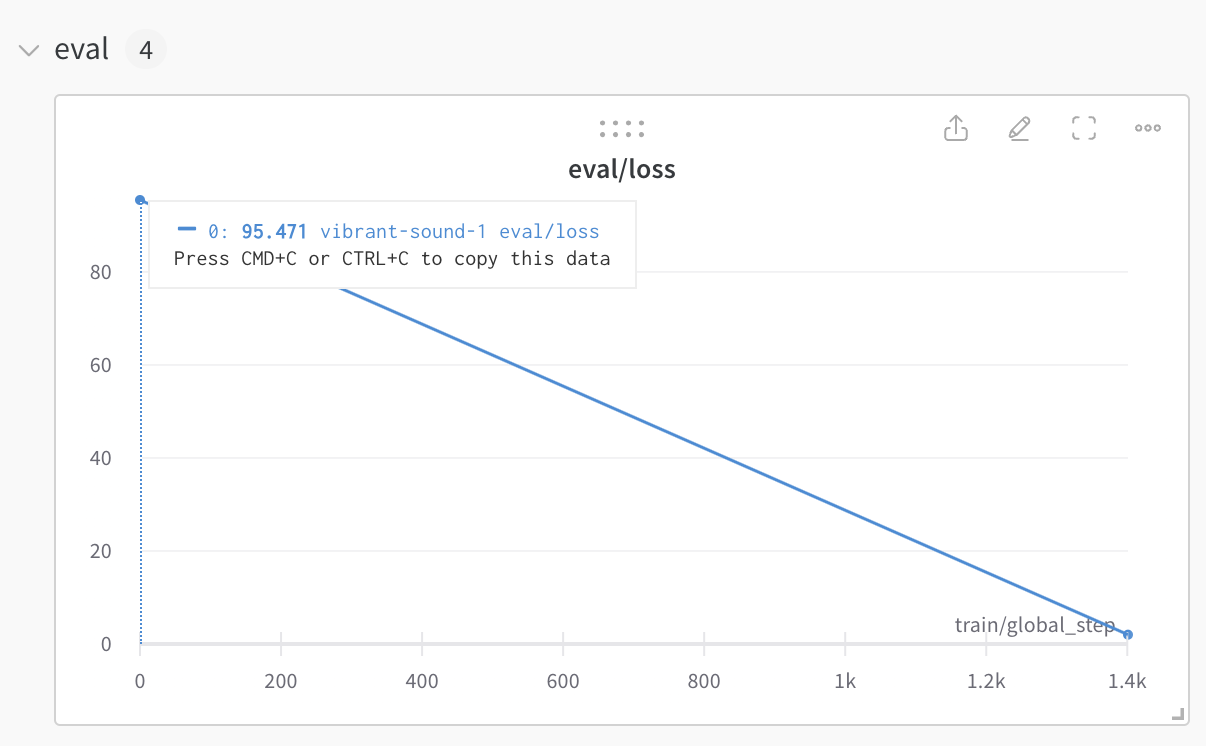